## Image Caption Generator ##

Consider the following image:

<img src="images/horse.png" width="400">

We can come up with several cations for the image such as: 
1. a man is riding a horse.
2. a cowboy is on the horse.
3. a horse is being ridden by a man with hat.

The list continues ...

As, humans we do this almost effortlessly and do not realize that this ease of giving relevant captions to images comes from our life long learnings and observations.

What if we want computer to do this task? Obviously, the computer doesn't share our consciousness, memory or experiences. Then, how do we train a computer to tell what is happening in the image?
Just prior to the recent advancement of Deep Neural Networks this problem was inconceivable even by the most advanced researchers in Computer Vision and NLP. But with the widescale adaptation of Deep Learning, this problem can be solved if we have the required dataset.

### Dataset Description ###
For this project, we use the famous FLickr 8k dataset. This dataset contains 8000 images (hence the name 8k) and each image has 5 captions telling us what is happening in the image.
These 8000 images are split as follows:
1. 6000 Training images and their descriptions.
2. 1000 Development/Validation images and their descriptions.
3. 1000 Test images and their descriptions

Let us start importing the images and descriptions, but before that we need to import all the necessary dependancies

Also, tensorflow, numpy use random numbers for sokme of their implementations. So out results could vary from run-to-run or session-to-session. To prevent this, we should fix the random seed in numpy, tensorflow and also force tensforflow to use single thread execution(if multi thread, it could result in randomness).

In [1]:
import tensorflow as tf
import random as rn
import os
import numpy as np

os.environ['PYTHONHASHSEED'] = '0'
# Setting the seed for numpy-generated random numbers
np.random.seed(37)
# Setting the seed for python random numbers
rn.seed(1254)
# Setting the graph-level random seed.
tf.set_random_seed(89)
from keras import backend as K
session_conf = tf.ConfigProto(
      intra_op_parallelism_threads=1,
      inter_op_parallelism_threads=1)
#Force Tensorflow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
# importing all the required packages
import re
import h5py
import json
import pickle
import random
from PIL import Image
from pickle import load
from helpers import Helpers
from data_load import DataLoad
from inference import Inference
from IPython.display import display
from keras.backend import clear_session
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from sb_preprocess import ImageDataPreprocess, TextDataPreprocess
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model, Sequential, model_from_json, load_model

### Using Pre-trained model to extract image features ###
Since we need to represent an image from our dataset in the form of a vector, we have to train a CNN model to get the vector representation of an image. Instead of training a custom CNN which takes significant of time to train and also is limited in it's capability(because of a smaller dataset), we can use pretrained models such as VGG-16, VGG-19, ResNet, InceptionV3 which were trained on much larger dataset and have much sophisticated architecture. Hence, these pre-trained models certainly better represent an image.

For this project, we use InceptionV3(version 3) model that was the first runner up in the ImageNet competetion in 2015.
Below is the architecture of the model:



<img src="images/inception.png" width="600">

More information about different versions of Inception models can be found here: https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202

We remove the very last layer of this model which basically is a fully connected layer with sigmoid activation. This layer assigns probability to all the 1000 classes and classify the image. When, we remove the last layer, we can get a 2048 dimensional vecotorial representation of the image. We use this vector along with descriptions(converted into sequences) to train our Caption Generator model.

Loading the pre-trained InceptionV3 model

In [ ]:
image_model = ImageDataPreprocess.get_pretrained_model('InceptionV3')

Pre-computing the image features and saving them.

The InceptionV3 network needs the input image to be of the shape (299, 299, 3). So we preprocess the image to be in such a shape.

In [ ]:
# computing and saving TextDataPreprocessures of all the images
ImageDataPreprocess.compute_save_features(pretrained_model=image_model, model_name='InceptionV3',img_dir='Flicker8k_Dataset',target_size=(299, 299))

Cleaning the descriptions and storing them

In [3]:
# getting a dictionary with image_id as key and list of descriptions as value
descriptions_dict = TextDataPreprocess.get_descriptions_dict(desc_path='Flicker8k_text/Flickr8k.token.txt', clean=True)
with open('pickle_files/all_descriptions_dict.pkl', 'wb') as pickle_file:
    pickle.dump(descriptions_dict, pickle_file)
# saving all the descriptions as text file 'descriptions.txt'
TextDataPreprocess.save_descriptions(descriptions_dict, path_to_save='descriptions.txt')

In [4]:
vocab_set =  TextDataPreprocess.get_vocab_set(descriptions_dict)
print('size of the vocabulary set: {}'.format(len(vocab_set)))

size of the vocabulary set: 8763


### Extracting train, dev and test data ###
The text files: "Flickr_8k.trainImages.txt", "Flickr_8k.devImages.txt", "Flickr_8k.testImages.txt"  contain names of the images that belong to the training, dev and test sets respectively. So we create a dictionary each for train, dev and test which has key as the image and list of descriptions for that image as value. 

Also, each description string is appended with two tokes/special strings: 'startseq' at the beginning ang 'endseq' at the end.
These special tokens indicate the start and end of the description/sequence to the model.

In [3]:
# loading and saving the dictionary of training descriptions
train_descriptions_dict = DataLoad.load_descriptions(path_to_ids='Flicker8k_text/Flickr_8k.trainImages.txt', descriptions_path='descriptions.txt')
with open('pickle_files/train_descriptions_dict.pkl', 'wb') as pickle_file:
    pickle.dump(train_descriptions_dict, pickle_file)

In [4]:
with open('pickle_files/train_descriptions_dict.pkl', 'rb') as pickle_file:
    train_descriptions_dict = pickle.load(pickle_file)

In [5]:
# loading and saving the dictionary of development descriptions
dev_descriptions_dict = DataLoad.load_descriptions(path_to_ids='Flicker8k_text/Flickr_8k.devImages.txt', descriptions_path='descriptions.txt')
with open('pickle_files/dev_descriptions_dict.pkl', 'wb') as pickle_file:
    pickle.dump(dev_descriptions_dict, pickle_file)

In [6]:
# loading and saving the dictionary of test descriptions
test_descriptions_dict = DataLoad.load_descriptions(path_to_ids='Flicker8k_text/Flickr_8k.testImages.txt', descriptions_path='descriptions.txt')
with open('pickle_files/test_descriptions_dict.pkl', 'wb') as pickle_file:
    pickle.dump(test_descriptions_dict, pickle_file)

We also extract and save the features of train, dev and test images from the pre-computed features computed and saved earlier.

In [7]:
train_images_dict = DataLoad.load_photo_features(path_to_ids='Flicker8k_text/Flickr_8k.trainImages.txt', features_path='pickle_files/image_features.pkl')
with open('pickle_files/train_image_features.pkl', 'wb') as pickle_file:
    pickle.dump(train_images_dict, pickle_file)

In [8]:
dev_images_dict = DataLoad.load_photo_features(path_to_ids='Flicker8k_text/Flickr_8k.devImages.txt', features_path='pickle_files/image_features.pkl')
with open('pickle_files/dev_image_features.pkl', 'wb') as pickle_file:
    pickle.dump(dev_images_dict, pickle_file)

In [9]:
test_images_dict = DataLoad.load_photo_features(path_to_ids='Flicker8k_text/Flickr_8k.testImages.txt', features_path='pickle_files/image_features.pkl')
with open('pickle_files/test_image_features.pkl', 'wb') as pickle_file:
    pickle.dump(test_images_dict, pickle_file)

The description text will need to be encoded to numbers before it can be presented to the model as in input or compared to the model’s predictions.
The first step in encoding the data is to create a consistent mapping from words to unique integer values. This is done by creating a dictionary of each word as key and its unique interger as value. A reverse mapping dictionary i.e. with interger ids as key and word as value is also created for inference purposes.

In [10]:
with open('pickle_files/word_to_id.pkl', 'rb') as pickle_file:
    word_to_id = pickle.load(pickle_file)
with open('pickle_files/id_to_word.pkl', 'rb') as pickle_file:
    id_to_word = pickle.load(pickle_file)
vocab_size = len(word_to_id) + 1

To input the sequences into the model, they all have to be of same length. Hence, we take the length of the longest sequence i.e length of the sentence with longest description and make this the length of every seqeunce by padding it with zeros.

In [11]:
max_length = Helpers.max_sentence_length(train_descriptions_dict)
print(max_length)

34


### Creating input-output pairs ###
Each description will be split into words. The model will be provided one word and the photo and generate the next word. Then the first two words of the description will be provided to the model as input with the image to generate the next word. This is how the model will be trained. For example a description 'little girl running on the field' is would be split into the following input output pairs:


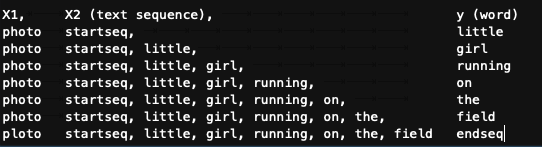

In [12]:
# loading the training, dev input-output pairs
train_x1, train_x2, train_y = Helpers.get_pairs(train_descriptions_dict, photo_features=train_images_dict, mappings_dict=word_to_id, max_length=max_length)
dev_x1, dev_x2, dev_y = Helpers.get_pairs(dev_descriptions_dict, photo_features=dev_images_dict, mappings_dict=word_to_id, max_length=max_length)

In [13]:
# loading the test input-output pairs
test_x1, test_x2, test_y = Helpers.get_pairs(test_descriptions_dict, photo_features=test_images_dict, mappings_dict=word_to_id, max_length=max_length)

### Building the Model ###

**Settings weights for embedding layer**

We load the embedding matrix that was computed and saved from the 'glove_embeddings.ipynb' notebook. This matrix is used to set the weights of embedding layer which converts each word in the sentence into its respective 100 dimensional embedding.

In [14]:
embedding_matrix = np.load('embedding_matrix.npy')
embedding_dim = embedding_matrix.shape[1]
print('shape of embedding matrix = {}'.format(embedding_matrix.shape))

shape of embedding matrix = (1652, 200)


In [15]:
# creating an embedding layer with embedding matrix as weights
embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], mask_zero=True, trainable=False, name='embedding')

**Building the neural network model**

We use LSTM(long-short term memory) architecture which is a modified version of RNN(recurrent NN) architecture, to process the text by taking sequential order of words into account.

In [16]:
# defining feature extractor model
#clear_session()
fe_inputs = Input(shape=(2048,))
fe_layer1 = Dropout(0.4)(fe_inputs)
fe_layer2 = Dense(256, activation='relu')(fe_layer1)
# sequence model
seq_inputs = Input(shape=(max_length,))
seq_layer1 = embedding_layer(seq_inputs)

seq_layer2 = Dropout(0.4)(seq_layer1)
seq_layer3 = LSTM(256)(seq_layer2)
# decoder model
decoder_layer1 = add([fe_layer2, seq_layer3])
decoder_layer2 = Dense(128, activation='relu')(decoder_layer1)
outputs = Dense(vocab_size, activation='softmax')(decoder_layer2)
# tie it together [image, seq] [word]
model = Model(inputs=[fe_inputs, seq_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Visualizing the model through model graph**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

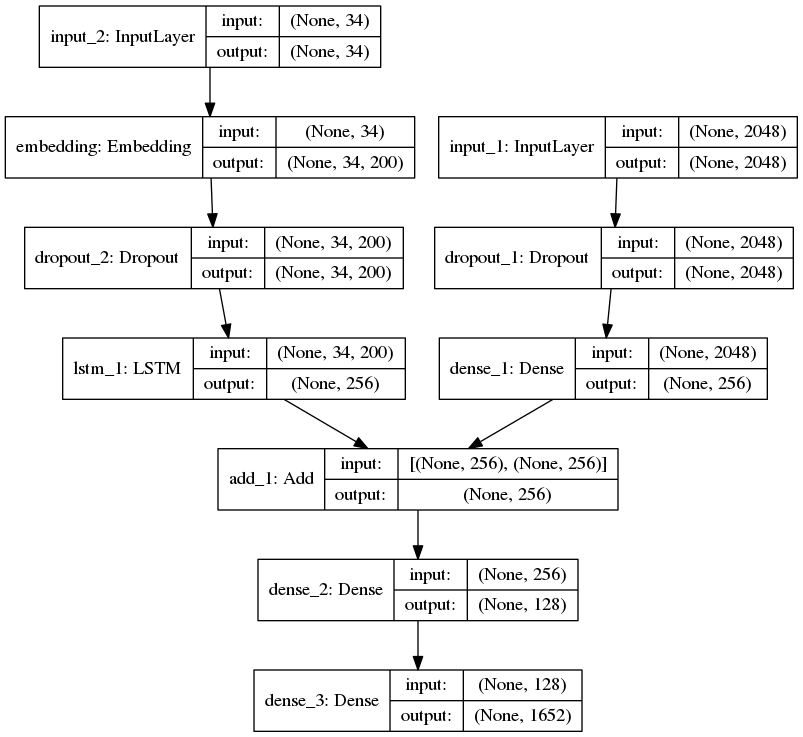

In [17]:
# summarize model
print(model.summary())
# if the 'plot_model' gives an error, just comment it and refer to 'model.png'
plot_model(model, to_file='model.png', show_shapes=True)

We use keras callbacks to save the best model only i.e. we save the model only when the loss on val/dev set has decreased from it's previous value. This is done to ensure that overfitting doesn't happen. Also this model could start overfitting very quickly and hence we used high dropout rate of 0.4 or 40%.

In [18]:
model_name = 'model/model_weights_200d.h5'
n_epochs =10
batch_size = 128

In [19]:
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit([train_x1, train_x2], train_y, epochs=n_epochs, batch_size=batch_size, validation_data=([dev_x1, dev_x2], dev_y), callbacks=[checkpoint])
model.save('after_model.h5')


Train on 292328 samples, validate on 48891 samples
Epoch 1/10
292328/292328 [==============================] - 993s 3ms/step - loss: 4.0594 - val_loss: 3.5673

Epoch 00001: val_loss improved from inf to 3.56734, saving model to model/model_weights_200d.h5
Epoch 2/10
292328/292328 [==============================] - 984s 3ms/step - loss: 3.3734 - val_loss: 3.3654

Epoch 00002: val_loss improved from 3.56734 to 3.36544, saving model to model/model_weights_200d.h5
Epoch 3/10
292328/292328 [==============================] - 987s 3ms/step - loss: 3.1693 - val_loss: 3.3117

Epoch 00003: val_loss improved from 3.36544 to 3.31168, saving model to model/model_weights_200d.h5
Epoch 4/10
292328/292328 [==============================] - 984s 3ms/step - loss: 3.0507 - val_loss: 3.2821

Epoch 00004: val_loss improved from 3.31168 to 3.28208, saving model to model/model_weights_200d.h5
Epoch 5/10
292328/292328 [==============================] - 980s 3ms/step - loss: 2.9659 - val_loss: 3.2751

Epoch 0

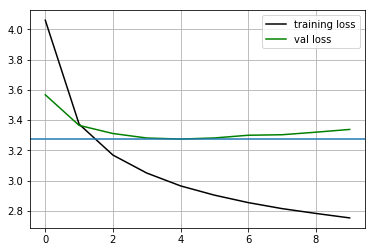

In [20]:
# plotting validation and training loss vs epochs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='black', label='training loss')
plt.plot(history.history['val_loss'], color='green', label = 'val loss')
plt.axhline(y=np.min(history.history['val_loss']))
plt.grid()
plt.legend()
plt.show()

We can see that after the 5th epoch, validation loss keeps increasing. This mostly means that the model is starting to overfit, but we still continue to train the model for remaining 15 epochs.

### Inference ###
We load the saved model and make predictions on the test images.

In [21]:
# loading the trained model
loaded_model = load_model('model/model_weights_200d.h5')

We follow the similar procedure of creating input-output pairs for inferences from the trained model. 

Below are the steps followed to generate caption for a test/new image: 
1. set the intital value of the string to 'startseq'.
2. input the extracted image feature vector and sequence representation of initial string i.e. 'startseq'.
3. concatenate the predicted word to the string and get the sequence representation of the updated string.
4. input the image image feature vector and the updated sequence representation to the model.
5. repreat steps 3 and 4 until model predicts 'endseq' or until the maximum length of the sequence is reached, which ever condition comes first.

To evaluate our model, we use something called BLEU score. BLEU score is mainly used in language translation tasks to measure of similar the predicted sentence is to the target sentence. It is also relevant here since our model predicts the description and we have a list of target descriptions to campare it to.

More about BLEU score can be found here: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

We can consider description to be good if BLEU score is close to 1 and bad if it is close to 0.

In [22]:
# inference on test images
actual, predicted = [], []
# step over the whole set
for key, desc_list in test_descriptions_dict.items():
    # generate description
    y_pred = Inference.generate_desc(loaded_model, word_to_id,id_to_word, test_images_dict[key], max_length)
    #print(y_pred, key)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(y_pred.split())
# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.585413
BLEU-2: 0.363603
BLEU-3: 0.271376
BLEU-4: 0.146253


We also do test on new images that are not at all included in the Flickr8k dataset. They must be placed in the 'new_images' folder before running the cells below.

In [26]:
image_name = 'soccer.jpg'
new_img_feature = Inference.get_image_features(inf_img_path='new_images/'+image_name)

In [27]:
new_description = Inference.generate_desc(loaded_model, word_to_id,id_to_word, new_img_feature, max_length)

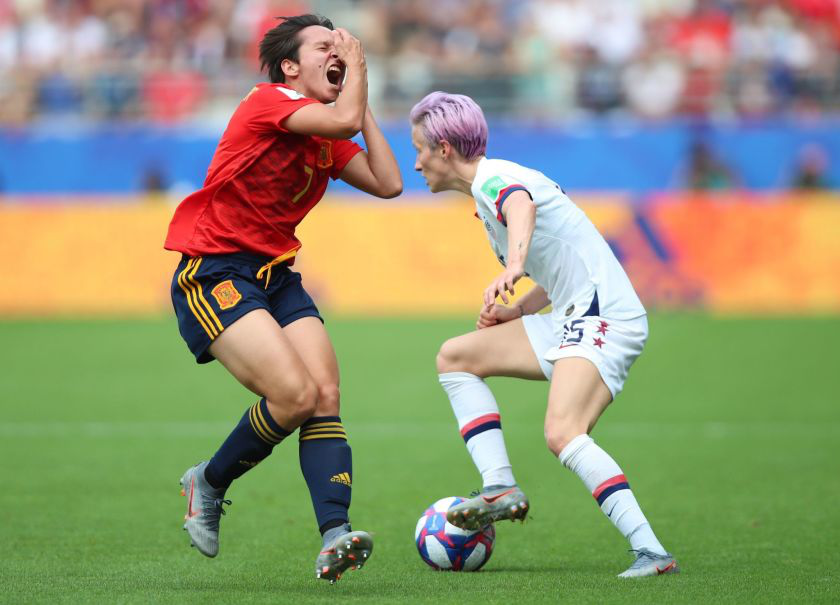

startseq two men in red and white uniforms are playing soccer endseq


In [28]:
display(Image.open('new_images/'+image_name))
print(new_description)

### Future Work ###

Some of the ideas to improve the performance of the model are:

1. Using a larger dataset like the MS-COCO data set : http://cocodataset.org/#download. This ensures that our model is exposed to a wide variety of images and descriptions and hence perform better during inference.
2. Doing more hyper parameter tuning (learning rate, batch size, number of layers, number of units, dropout rate, batch normalization etc.) like a grid search using dev set.
3. Using Beam Search instead of Greedy Search during Inference.
4. Try reducing the size of vocabulary. Many of the words might appear less than 5 or 10 times. Eliminating these can imporve the performance of the model.

### Applications ###

This cool application can open doors to some of the amazing possibilities that were only seen in sci-fi movies until now. Some of them are:

1. Self/Automatic driving is one of the biggest challenges and if we can properly caption the scene around the car, it can give a boost to the self driving system.
2. We can create a product for the blind which will guide them to travel on roads or a product that automatically translates what is happening in the photo/video into speech. We can do this by first converting the scene into text and then the text to voice. Both are now some of the bleeding edge applications of Deep Learning.
3. CCTV cameras are everywhere today, but along with viewing the world, if we can also generate relevant captions, then we can raise alarms as soon as there is some malicious activity going on somewhere. This could probably help reduce some crime and/or accidents.
4. Automatic Captioning can make Image Search as good as web browsing, as then every image could be first converted into a caption and then search can be performed based on the caption.